In [1]:
import MDAnalysis as mda
import os
import numpy as np
from MDAnalysis import Universe
from MDAnalysis.analysis import rdf
from MDAnalysis import transformations

file1 = os.path.join('cp2k-pos-1.xyz')
# file1 = os.path.join('cp2k-pos-test.xyz')
u = Universe(file1)



/raid/hwding/anaconda3/envs/gpumd/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# import MDAnalysis as mda
# import os
# import numpy as np
# from MDAnalysis import Universe
# from MDAnalysis import transformations
# import matplotlib.pyplot as plt

# # file1 = os.path.join('cp2k-pos-1.xyz')
# path = '/raid/hwding/cp2k/lmp-pre/6-6-d-0.5_inf-lmp_more'
# file1 = os.path.join(path,'dump.xyz.300.pie')
# u = Universe(file1, format='LAMMPSDUMP')

# O_atoms = u.select_atoms('type 3')  # C 1, H 2, O 3
print(len(u.trajectory))

20001


In [3]:

# 设置模拟盒的维度
dim = np.array([28.136, 28.136, 14.757, 90, 90, 90])  # 盒子维度
transform = mda.transformations.boxdimensions.set_dimensions(dim)
u.trajectory.add_transformations(transform)


# 移动到第一帧（index = 0）
u.trajectory[0]


def pbc_z(dz1, dz2, boxz):
    # 原始差值的绝对值
    dz = abs(dz2 - dz1)

    # 如果超过半个盒长，就从另一侧量：boxz - dz
    if dz > boxz / 2.0:
        dz = boxz - dz
    # 否则不用变

    return dz

# # 选择氧原子
# O_atoms = u.select_atoms('name O')

# H_atoms = u.select_atoms('name H')

# O1 = O_atoms[0]

# for H in H_atoms:
#     dz = pbc_z(O1.position[2], H.position[2], u.dimensions[2])
#     print(f'Distance in z between O1 and H: {dz:.3f} Å')



In [4]:
## 1.求出n_total
radius = 4.068
def calc_volume(r:float, l:float):
    """_summary_

    Args:
        r (float): radius of the nanotube
        l (float): length of the nanotube

    Returns:
        _type_: volume
    """
    return np.pi * r**2 * l

# v = calc_volume(radius, u.dimensions[2])
# n_tot = len(O_atoms)/v

# print(n_tot)

In [5]:
import numpy as np


def count_1atom_rdf(u, atom1,atoms2, nbins,radius=4.068):
    """
    以第一个 O 原子 O1 为中心，按 z 方向最小像距离分 bin 统计 Ni。

    Parameters
    ----------
    u : MDAnalysis.Universe
        体系的 Universe 对象，用于获取盒子尺寸。
    O_atoms : AtomGroup
        所有 O 原子的 AtomGroup。
    nbins : int, optional
        z 方向 bin 的数量，默认 60。

    Returns
    -------
    Ni : np.ndarray (shape: nbins)
        每个 bin 中的原子计数。
    dz_bin : float
        每个 bin 的宽度 (Å)。
    """
    # 盒长和 bin 宽度
    Lz = u.dimensions[2]
    dz_bin = (Lz * 0.5) / nbins   # 只用取一半就行

    # 用一个数组保存每个 bin 对应的计数 Ni，初始化为 0
    Ni = np.zeros(nbins, dtype=int)

    # 以第一个 O 原子为中心
    

    for atom in atoms2:
        if atom == atom1:
            continue  # 跳过自己
        # 1. 计算 O1 与 O 的 z 方向最小像距离（绝对值）
        dz = pbc_z(atom1.position[2], atom.position[2], Lz)

        # 2. 判断这个 dz 落在第几个 bin
        #    你只用 0 ~ Lz/2，所以这里条件改成 < Lz*0.5 更一致
        if 0 <= dz < Lz * 0.5:
            bin_index = int(dz / dz_bin)   # floor(dz/dz_bin)

            # 3. 防止 dz 恰好等于 Lz*0.5 的边界情况
            if bin_index == nbins:
                bin_index = nbins - 1

            # 4. 对应 bin 的计数 +1
            Ni[bin_index] += 1
    
    ##统计算一下rdf        
    g = np.zeros(nbins)

    v = calc_volume(radius, u.dimensions[2])
    n_tot = len(atoms2)/v

    N_tot = len(atoms2)

    for i in range(nbins):
        vol_i = calc_volume(radius, dz_bin)
        # 关键：给第 i 个 bin 赋值，而不是覆盖整个 g
        g[i] = Ni[i] / (2*vol_i * n_tot )

    return Ni, dz_bin,g

Using nbins = 37


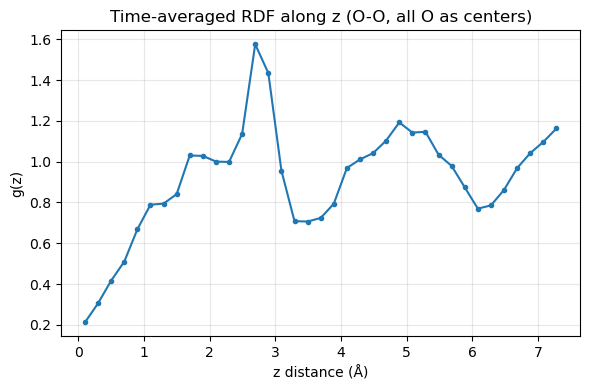

In [6]:
## 算 O-O的 rdf
import numpy as np
import matplotlib.pyplot as plt

def count_rdf_layers(u, atoms1,atoms2, nbins=100):
    
    g_sum = None

    dz_bin = None

    for atom_center in atoms1:
        Ni_i, dz_bin_i, g_i = count_1atom_rdf(u, atom_center, atoms2, nbins, radius=4.068)

        if g_sum is None:
            g_sum = np.zeros_like(g_i, dtype=float)
            dz_bin = dz_bin_i   # 记录第一个的 dz_bin

        g_sum += g_i
    N_avg = len(atoms1)
    g_avg = g_sum / N_avg

    return g_avg, dz_bin

# =========================
# 时间循环：对所有帧取平均
# =========================

nbins = round((u.dimensions[2]*0.5)/0.2)
print("Using nbins =", nbins)
g_all = []        # 保存每一帧的 g_avg
dz_bin_ref = None

for ts in u.trajectory[0:20000]:
    O_atoms = u.select_atoms('type O')

    g_avg_frame, dz_bin = count_rdf_layers(u, O_atoms, O_atoms, nbins=nbins)
    g_all.append(g_avg_frame)

    # 记录第一帧的 dz_bin，后面可以检查是否变化
    if dz_bin_ref is None:
        dz_bin_ref = dz_bin
    else:
        # 如果盒子变化较大，这里可以加一个检查
        if not np.isclose(dz_bin_ref, dz_bin):
            print("Warning: dz_bin changed between frames:", dz_bin_ref, dz_bin)

g_all = np.array(g_all)           # 形状 (n_frames, nbins)
g_time_avg = g_all.mean(axis=0)   # 对所有帧平均，得到时间平均 g(z)

# =========================
# 构造 z 轴坐标并画图
# =========================
# 这里 z 从 0 ~ Lz/2，每个 bin 宽度是 dz_bin_ref
nbins = len(g_time_avg)
z_centers = (np.arange(nbins) + 0.5) * dz_bin_ref   # 每个 bin 的中心

plt.figure(figsize=(6, 4))
plt.plot(z_centers, g_time_avg, '-o', markersize=3)
plt.xlabel('z distance (Å)')
plt.ylabel('g(z)')
plt.title('Time-averaged RDF along z (O-O, all O as centers)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ===== 把 z_centers 和 g_time_avg 各存为一行 =====
np.savetxt(
    "rdf_zz_cp2k.txt",
    np.vstack((z_centers, g_time_avg)),
    header="z_centers (Angstrom)\ng_time_avg",
)

Using nbins = 37


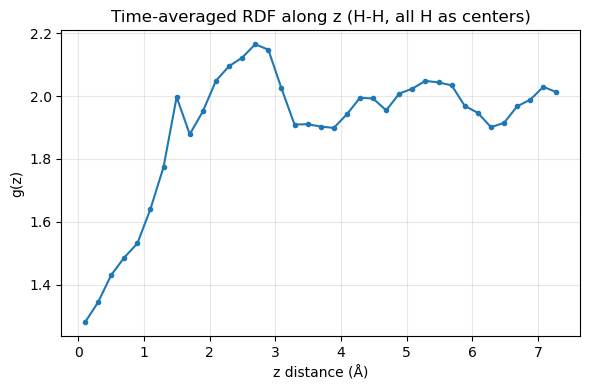

In [20]:
## 算 H-H 的 ADF
nbins = round((u.dimensions[2]*0.5)/0.2)
print("Using nbins =", nbins)
g_all = []        # 保存每一帧的 g_avg
dz_bin_ref = None

for ts in u.trajectory:
    H_atoms = u.select_atoms('name H')

    g_avg_frame, dz_bin = count_rdf_layers(u, H_atoms, H_atoms, nbins=nbins)
    g_all.append(g_avg_frame)

    # 记录第一帧的 dz_bin，后面可以检查是否变化
    if dz_bin_ref is None:
        dz_bin_ref = dz_bin
    else:
        # 如果盒子变化较大，这里可以加一个检查
        if not np.isclose(dz_bin_ref, dz_bin):
            print("Warning: dz_bin changed between frames:", dz_bin_ref, dz_bin)

g_all = np.array(g_all)           # 形状 (n_frames, nbins)
g_time_avg = g_all.mean(axis=0)   # 对所有帧平均，得到时间平均 g(z)

# =========================
# 构造 z 轴坐标并画图
# =========================
# 这里 z 从 0 ~ Lz/2，每个 bin 宽度是 dz_bin_ref
nbins = len(g_time_avg)
z_centers = (np.arange(nbins) + 0.5) * dz_bin_ref   # 每个 bin 的中心

plt.figure(figsize=(6, 4))
plt.plot(z_centers, g_time_avg, '-o', markersize=3)
plt.xlabel('z distance (Å)')
plt.ylabel('g(z)')
plt.title('Time-averaged RDF along z (H-H, all H as centers)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Using nbins = 37


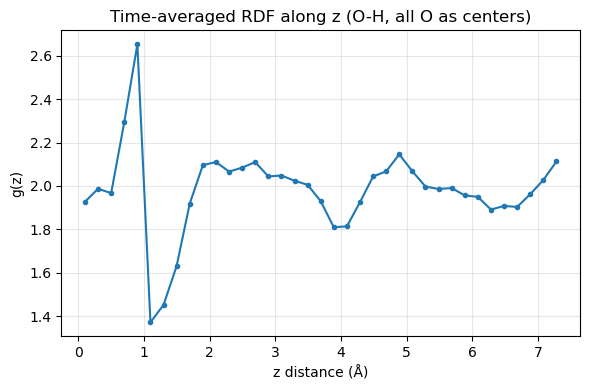

In [21]:
## 算 O-H 的 ADF
nbins = round((u.dimensions[2]*0.5)/0.2)
print("Using nbins =", nbins)
g_all = []        # 保存每一帧的 g_avg
dz_bin_ref = None

for ts in u.trajectory:
    O_atoms = u.select_atoms('name O')
    H_atoms = u.select_atoms('name H')
    g_avg_frame, dz_bin = count_rdf_layers(u, O_atoms, H_atoms, nbins=nbins)
    g_all.append(g_avg_frame)

    # 记录第一帧的 dz_bin，后面可以检查是否变化
    if dz_bin_ref is None:
        dz_bin_ref = dz_bin
    else:
        # 如果盒子变化较大，这里可以加一个检查
        if not np.isclose(dz_bin_ref, dz_bin):
            print("Warning: dz_bin changed between frames:", dz_bin_ref, dz_bin)

g_all = np.array(g_all)           # 形状 (n_frames, nbins)
g_time_avg = g_all.mean(axis=0)   # 对所有帧平均，得到时间平均 g(z)

# =========================
# 构造 z 轴坐标并画图
# =========================
# 这里 z 从 0 ~ Lz/2，每个 bin 宽度是 dz_bin_ref
nbins = len(g_time_avg)
z_centers = (np.arange(nbins) + 0.5) * dz_bin_ref   # 每个 bin 的中心

plt.figure(figsize=(6, 4))
plt.plot(z_centers, g_time_avg, '-o', markersize=3)
plt.xlabel('z distance (Å)')
plt.ylabel('g(z)')
plt.title('Time-averaged RDF along z (O-H, all O as centers)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [111]:
import MDAnalysis as mda
import maicos
from maicos.modules.pdfcylinder import PDFCylinder
import matplotlib.pyplot as plt
import numpy as np


pdf = PDFCylinder(
    g1=O_atoms,
    g2=O_atoms,
    bin_width=0.1,   # 径向分箱宽度
    drwidth=0.1,     # 圆柱壳厚度
    zmin=None,
    zmax=7.3785,
    rmin=0.0,        # 从中心开始
    rmax=4.068,       # 到盒子边界
    origin=None,
    unwrap=False,
    pack=True,
    bin_method="com",
).run()

z = pdf.results
print(z )


KeyboardInterrupt: 